In [46]:
import vk_api
import time
import pandas as pd
from datetime import datetime
from config import token

session = vk_api.VkApi(token)

## Получаем даннные

In [47]:
# --- Ваши данные ---
USER_ID = 'erglerik'    # screen_name или owner_id (для группы — со знаком минус)
MAX_POSTS = 300
BATCH_SIZE = 50

# --- Инициализация ---
vk_session = vk_api.VkApi(token=token)
vk = vk_session.get_api()

# --- Сбор постов ---
all_posts = []
offset = 0

## Извлекаем данные в датафрейм

In [48]:
while len(all_posts) < MAX_POSTS:
    count = min(BATCH_SIZE, MAX_POSTS - len(all_posts))

    response = vk.wall.get(
        owner_id=USER_ID,
        count=count,
        offset=offset,
        extended=0
    )

    items = response.get('items', [])
    if not items:
        break

    all_posts.extend(items)
    offset += count

    time.sleep(0.4)  # Не перегружаем API

# --- Обработка данных ---
posts_data = []

for i, post in enumerate(all_posts, 1):
    post_datetime = datetime.fromtimestamp(post['date'])
    likes = post.get('likes', {}).get('count', 0)

    posts_data.append({
        'Номер поста': i,
        'Дата': post_datetime.date(),
        'Время': post_datetime.time(),
        'Лайки': likes,
    })

# Создаем DataFrame
df = pd.DataFrame(posts_data)

df.head(10)

,Номер поста,Дата,Время,Лайки
0,1,2024-07-02,02:18:12,117
1,2,2025-07-18,02:14:18,79
2,3,2025-06-27,19:15:28,57
3,4,2025-06-27,19:14:45,48
4,5,2025-04-26,03:01:58,106
5,6,2024-11-01,23:24:29,83
6,7,2024-10-19,02:25:31,60
7,8,2024-10-19,02:24:28,73
8,9,2024-10-19,02:23:50,105
9,10,2024-09-11,03:31:46,111


## Добавляем колонку для дней недели

In [49]:
days_ru = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
df['День недели'] = pd.to_datetime(df['Дата']).dt.dayofweek.map(lambda x: days_ru[x])

df.head()

,Номер поста,Дата,Время,Лайки,День недели
0,1,2024-07-02,02:18:12,117,Вторник
1,2,2025-07-18,02:14:18,79,Пятница
2,3,2025-06-27,19:15:28,57,Пятница
3,4,2025-06-27,19:14:45,48,Пятница
4,5,2025-04-26,03:01:58,106,Суббота


## Выкидываем первый пост тк он закрепленный (выброс)

In [50]:
df = df.drop(df.index[0])
df.head(25)

,Номер поста,Дата,Время,Лайки,День недели
1,2,2025-07-18,02:14:18,79,Пятница
2,3,2025-06-27,19:15:28,57,Пятница
3,4,2025-06-27,19:14:45,48,Пятница
4,5,2025-04-26,03:01:58,106,Суббота
5,6,2024-11-01,23:24:29,83,Пятница
6,7,2024-10-19,02:25:31,60,Суббота
7,8,2024-10-19,02:24:28,73,Суббота
8,9,2024-10-19,02:23:50,105,Суббота
9,10,2024-09-11,03:31:46,111,Среда
10,11,2024-08-25,01:06:09,61,Воскресенье


## Время с предыдущего поста

In [51]:
# Создаем полные метки времени
df['Дата и время'] = pd.to_datetime(df['Дата'].astype(str) + ' ' + df['Время'].astype(str))

# Сортируем по возрастанию даты (старые посты выше)
df = df.sort_values('Дата и время', ascending=True)

# Вычисляем разницу с предыдущим постом
df['Разница с предыдущим'] = df['Дата и время'].diff()

# Считаем общее количество минут с предыдущего поста
df['Минут с предыдущего'] = df['Разница с предыдущим'].apply(
    lambda x: x.total_seconds() / 60 if pd.notnull(x) else None
).astype('float')

# Удаляем временную колонку
df = df.drop(columns=['Разница с предыдущим', 'Дата и время'])

# Возвращаем исходный порядок (если нужно)
df = df.sort_values('Номер поста')

# Выводим результат
df.head(20)
df.dtypes

Номер поста              int64
Дата                    object
Время                   object
Лайки                    int64
День недели             object
Минут с предыдущего    float64
dtype: object

## Создаем нужные признаки, ненужные не создаем, совсем ненужные удаляем.

In [52]:
df['Час'] = pd.to_datetime(df['Время'], format='%H:%M:%S').dt.hour

def время_суток(час):
    if 6 <= час < 12:
        return 'утро'
    elif 12 <= час < 18:
        return 'день'
    elif 18 <= час < 24:
        return 'вечер'
    else:
        return 'ночь'

df['Время суток'] = df['Час'].apply(время_суток)
df = df.drop(columns=["Час"]) #"Дней с предыдущего","Часов с предыдущего","Дата","Время"])
df.head(10)

,Номер поста,Дата,Время,Лайки,День недели,Минут с предыдущего,Время суток
1,2,2025-07-18,02:14:18,79,Пятница,29218.833333,ночь
2,3,2025-06-27,19:15:28,57,Пятница,0.716667,вечер
3,4,2025-06-27,19:14:45,48,Пятница,90252.783333,вечер
4,5,2025-04-26,03:01:58,106,Суббота,252217.483333,ночь
5,6,2024-11-01,23:24:29,83,Пятница,19978.966667,вечер
6,7,2024-10-19,02:25:31,60,Суббота,1.050000,ночь
7,8,2024-10-19,02:24:28,73,Суббота,0.633333,ночь
8,9,2024-10-19,02:23:50,105,Суббота,54652.066667,ночь
9,10,2024-09-11,03:31:46,111,Среда,24625.616667,ночь
10,11,2024-08-25,01:06:09,61,Воскресенье,0.766667,ночь


## Колонки "Праздник" и "Время года"

In [53]:
import holidays
import numpy as np

In [54]:
df['Дата'] = pd.to_datetime(df['Дата'])
ru_holidays = holidays.RU(years=df['Дата'].dt.year.unique())

def is_holiday_or_weekend(date):
    return date in ru_holidays or date.weekday() >= 5  # 5,6 — суббота, воскресенье

df['Праздник'] = df['Дата'].apply(is_holiday_or_weekend)


In [55]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

df['Время года'] = df['Дата'].apply(get_season)

In [56]:
df.head()
df.shape

(299, 9)

In [57]:
df['Лайки'].median()

np.float64(8.0)

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

In [59]:
df_for_train = df.copy()

## Обучаем лес 

In [60]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error


R²: 0.080
MAE: 20.68 лайков


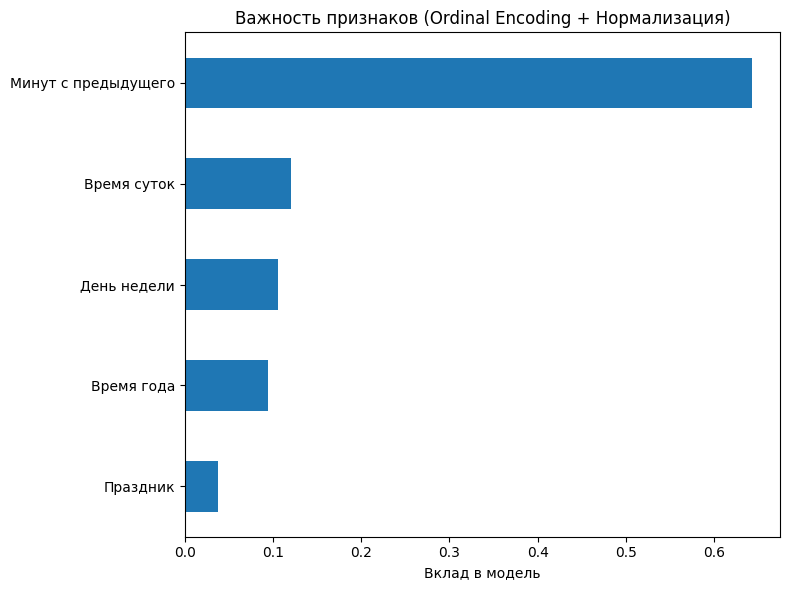

In [61]:
# Удалим пробелы в названиях колонок
df.columns = df.columns.str.strip()

# Копия исходного датафрейма
df_model = df.copy()

# Категориальные признаки
categorical_cols = ['Время суток', 'Праздник', 'Время года', 'День недели']

# Ordinal Encoding
encoder = OrdinalEncoder()
df_model[categorical_cols] = encoder.fit_transform(df_model[categorical_cols])

# Формируем X и y
X = df_model.drop(columns=['Номер поста', 'Дата', 'Время', 'Лайки'])
y = df_model['Лайки']

# Масштабирование (нормализация)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Обучаем модель
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Метрики
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'R²: {r2:.3f}')
print(f'MAE: {mae:.2f} лайков')

# Важности признаков
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values()

# График
plt.figure(figsize=(8, 6))
importances.plot(kind='barh')
plt.title('Важность признаков (Ordinal Encoding + Нормализация)')
plt.xlabel('Вклад в модель')
plt.tight_layout()
plt.show()
